In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-01-31 15:37:06.759724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 15:37:07.298094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ivv101/arrayfire/lib64:/usr/local/cuda/lib64:/home/ivv101/arrayfire/lib64:/usr/local/cuda/lib64::/home/ivv101/miniconda3/envs/p310/lib/:/home/ivv101/miniconda3/envs/p310/lib/
2023-01-31 15:37:07.298188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
SEED = 321

In [4]:
log_features = ['Fs', 'Fm', 'Fh', 'Fb', 
                'rgeo', 'b_rgeo', 'B_rgeo',
                'PM'
               ]

features = ['Fs', 'Fm', 'Fh', 'Fb',
            'P_intra', 'P_inter',
            'Gmag', 'BPmag', 'RPmag', 'Jmag', 'Hmag', 'Kmag',
            'W1mag', 'W2mag', 'W3mag',
            'Plx', 'PM',
            'rgeo', 'b_rgeo', 'B_rgeo'
           ]

errors = ['e_Fs', 'e_Fm', 'e_Fh', 'e_Fb',
          'e_Gmag', 'e_BPmag', 'e_RPmag', 'e_Jmag', 'e_Hmag', 'e_Kmag',
          'e_W1mag', 'e_W2mag', 'e_W3mag', 
          'e_Plx']

In [5]:
raw_df = pd.read_csv('TD.csv')
raw_df[log_features] = raw_df[log_features].apply(np.log10)
raw_df

,CSCv2_name,CSCv2_RA,CSCv2_DEC,CSCv2_PU,CSCv2_S/N,Fs,e_Fs,Fm,e_Fm,Fh,...,e_P_NS,e_P_YSO,Class,Class_prob,e_Class_prob,CT,CSCv2_flags,Catalog_name,True_Class,Class_ref
0,2CXO J000009.3+135618,0.039115,13.938493,0.79,1.95,-14.698970,1.000000e-15,-15.301030,5.000000e-16,-14.698970,...,0.0040,0.0500,AGN,0.900,0.100,5.307,NaN,SDSS J00001+1356,AGN,2010A&A...518A..10V
1,2CXO J000230.7+004959,0.627974,0.833072,0.72,11.07,-13.244125,7.000000e-15,-13.537602,5.000000e-15,-13.221849,...,0.0003,0.0004,AGN,0.999,0.004,145.799,NaN,PB 5698,AGN,2010A&A...518A..10V
2,2CXO J000622.6-000424,1.594324,-0.073573,0.78,25.42,-12.823909,1.000000e-14,-12.931814,8.000000e-15,-12.397940,...,0.0050,0.0009,AGN,0.970,0.020,20.820,extent,3C 2.0,AGN,2010A&A...518A..10V
3,2CXO J000659.2-001740,1.747051,-0.294661,0.84,4.11,-13.958607,4.000000e-15,-14.221849,3.000000e-15,-13.853872,...,0.0030,0.0070,AGN,0.950,0.060,8.318,NaN,SDSS J00069-0017,AGN,2010A&A...518A..10V
4,2CXO J000703.6+155423,1.765007,15.906575,0.72,8.63,-14.301030,3.000000e-15,-13.795880,6.000000e-15,-12.267606,...,0.0004,0.0090,AGN,0.990,0.010,47.057,NaN,2MASS J00070+1554,AGN,2010A&A...518A..10V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2CXO J183000.6+011340,277.502734,1.227794,0.71,20.82,-14.657577,4.000000e-16,-13.795880,1.000000e-15,-13.200659,...,0.0010,0.0300,YSO,0.930,0.030,16.735,NaN,2MASS J18300065+0113402,YSO,2007A&A...463..275G
2937,2CXO J183001.1+011324,277.504621,1.223367,0.75,8.10,-16.154902,7.000000e-17,-15.000000,3.000000e-16,-13.795880,...,0.0010,0.0900,YSO,0.800,0.090,3.192,NaN,2MASS J18300111+0113242,YSO,2007A&A...463..275G
2938,2CXO J183003.4+011619,277.514213,1.271981,0.73,13.69,-14.508638,5.000000e-16,-14.136677,8.000000e-16,-13.744727,...,0.0000,0.0050,YSO,0.998,0.005,124.848,NaN,2MASS J18300341+0116191,YSO,2007A&A...463..275G
2939,2CXO J183007.7+011204,277.532159,1.201211,0.75,15.60,-14.420216,6.000000e-16,-14.000000,1.000000e-15,-13.619789,...,0.0000,0.0070,YSO,0.996,0.007,84.887,extent,2MASS J18300770+0112043,YSO,2007A&A...463..275G


In [6]:
raw_df[features].describe()

,Fs,Fm,Fh,Fb,P_intra,P_inter,Gmag,BPmag,RPmag,Jmag,Hmag,Kmag,W1mag,W2mag,W3mag,Plx,PM,rgeo,b_rgeo,B_rgeo
count,2941.000000,2941.000000,2941.000000,2941.000000,2722.000000,1341.000000,2226.000000,2202.000000,2207.000000,1824.000000,1824.000000,1824.000000,2237.000000,2216.000000,1800.000000,1979.000000,1979.000000,1979.000000,1979.000000,1979.000000
mean,-14.497734,-14.429487,-13.966288,-13.607307,0.707645,0.825122,16.901351,17.057420,15.664129,13.108130,12.169211,11.528065,12.723278,12.059335,9.552933,1.426291,0.100477,3.098934,2.999408,3.200470
std,1.008959,0.843236,0.988348,0.811826,0.308620,0.270897,3.235986,3.200412,3.155636,2.623282,2.476145,2.350183,3.240621,3.086468,2.559758,2.190257,0.729921,0.524830,0.470019,0.588645
min,-17.096910,-17.096910,-17.096910,-15.522879,0.000000,0.002000,3.323000,4.023000,2.648000,1.500000,0.500000,0.100000,-1.800000,-2.000000,-6.650000,-4.000000,-2.522879,1.491362,1.491362,1.491362
25%,-15.154902,-14.970616,-14.522879,-14.167491,0.485000,0.726000,15.081500,15.090000,13.481500,11.357500,10.480000,9.930000,9.980000,9.620000,8.090000,0.000000,-0.419075,2.599883,2.586587,2.618571
50%,-14.420216,-14.397940,-13.920819,-13.638272,0.827000,0.994000,17.724500,17.960000,16.348000,13.070000,11.955000,11.265000,13.200000,12.460000,10.125000,0.600000,0.143951,3.192289,3.044932,3.304921
75%,-13.769551,-13.853872,-13.337242,-13.091515,0.990000,1.000000,19.360750,19.500000,18.240000,15.320000,14.200000,13.335000,15.470000,14.510000,11.500000,2.490000,0.626340,3.530200,3.356599,3.707996
max,-11.432974,-11.602060,-10.335358,-10.334419,1.000000,1.000000,21.860000,22.600000,21.000000,18.680000,17.940000,16.970000,18.900000,18.300000,13.650000,31.800000,1.996665,4.317646,4.221701,4.568108


In [7]:
# file = tf.keras.utils
# raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
# raw_df.head()

In [8]:
# raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [9]:
# neg, pos = np.bincount(raw_df['Class'])
# total = neg + pos
# print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
#     total, pos, 100 * pos / total))

This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [10]:
cleaned_df = raw_df.copy()

train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=SEED)

train_labels = train_df['True_Class'].to_numpy()
test_labels = test_df['True_Class'].to_numpy()

train_features = train_df[features].to_numpy()
test_features = test_df[features].to_numpy()

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [11]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

# val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
# print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (2352,)
Test labels shape: (589,)
Training features shape: (2352, 20)
Test features shape: (589, 20)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

In [33]:
train_features

array([[-0.41917577, -0.94529598, -0.75737796, ...,  0.62048353,
         0.51879066,  0.9095485 ],
       [-0.71655689, -0.11362223,  0.32413271, ...,         nan,
                nan,         nan],
       [-2.56888999, -0.54575168,  0.91832226, ...,         nan,
                nan,         nan],
       ...,
       [-0.14005401, -0.47180462, -0.4504412 , ...,  0.54775143,
         0.76727789,  0.36583929],
       [ 1.10617618,  1.02178909,  1.05566387, ...,         nan,
                nan,         nan],
       [-0.41917577, -0.73577271, -1.02210983, ..., -0.95872718,
        -0.88917538, -0.99621407]])

In [13]:
# pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
# neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

# sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# plt.suptitle("Positive distribution")

# sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
#               kind='hex', xlim=(-5,5), ylim=(-5,5))
# _ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics)

    return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [22]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [23]:
model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                336       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [30]:
# _ = train_features[:10].copy()
# _[np.isnan(_)] = 0
# _

Test run the model:

In [29]:
model.predict(_)

1/1 [==============================] - 0s 13ms/step


array([[0.8222713 ],
       [0.7341622 ],
       [0.5846522 ],
       [0.75574845],
       [0.7787603 ],
       [0.72934   ],
       [0.8577889 ],
       [0.73956424],
       [0.7339835 ],
       [0.67556816]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [25]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

2023-01-31 15:41:40.685201: W tensorflow/core/framework/op_kernel.cc:1807] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node 'categorical_crossentropy/Cast' defined at (most recent call last):
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_273963/972204898.py", line 1, in <module>
      results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 2040, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function
      return step_function(self, iterator)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step
      outputs = model.test_step(data)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 1758, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ivv101/miniconda3/envs/p310/lib/python3.10/site-packages/keras/losses.py", line 1991, in categorical_crossentropy
      y_true = tf.cast(y_true, y_pred.dtype)
Node: 'categorical_crossentropy/Cast'
2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to float is not supported
	 [[{{node categorical_crossentropy/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_1985]

The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 50ms/step


array([[0.00110731],
       [0.00280909],
       [0.00413586],
       [0.00342205],
       [0.00166295],
       [0.00368322],
       [0.00099343],
       [0.00190527],
       [0.00081247],
       [0.00266587]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0101


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

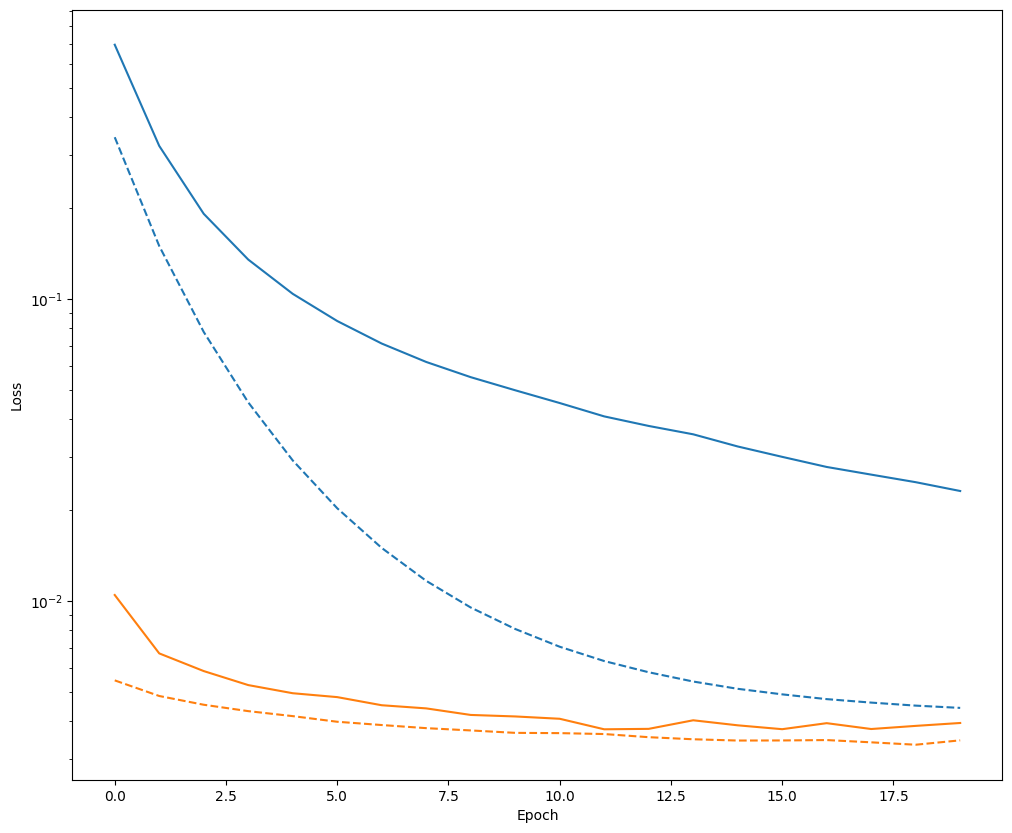

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 11ms/step - loss: 0.0108 - tp: 156.0000 - fp: 138.0000 - tn: 227312.0000 - fn: 239.0000 - accuracy: 0.9983 - precision: 0.5306 - recall: 0.3949 - auc: 0.8656 - prc: 0.3547 - val_loss: 0.0055 - val_tp: 44.0000 - val_fp: 8.0000 - val_tn: 45480.0000 - val_fn: 37.0000 - val_accuracy: 0.9990 - val_precision: 0.8462 - val_recall: 0.5432 - val_auc: 0.9051 - val_prc: 0.6984
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0067 - tp: 153.0000 - fp: 34.0000 - tn: 181928.0000 - fn: 161.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.4873 - auc: 0.9011 - prc: 0.5735 - val_loss: 0.0048 - val_tp: 49.0000 - val_fp: 10.0000 - val_tn: 45478.0000 - val_fn: 32.0000 - val_accuracy: 0.9991 - val_precision: 0.8305 - val_recall: 0.6049 - val_auc: 0.9131 - val_prc: 0.7129
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0058 - tp: 163.0000 - fp: 28.0000 - tn: 181934.0000 - fn: 151.0000 - accurac

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

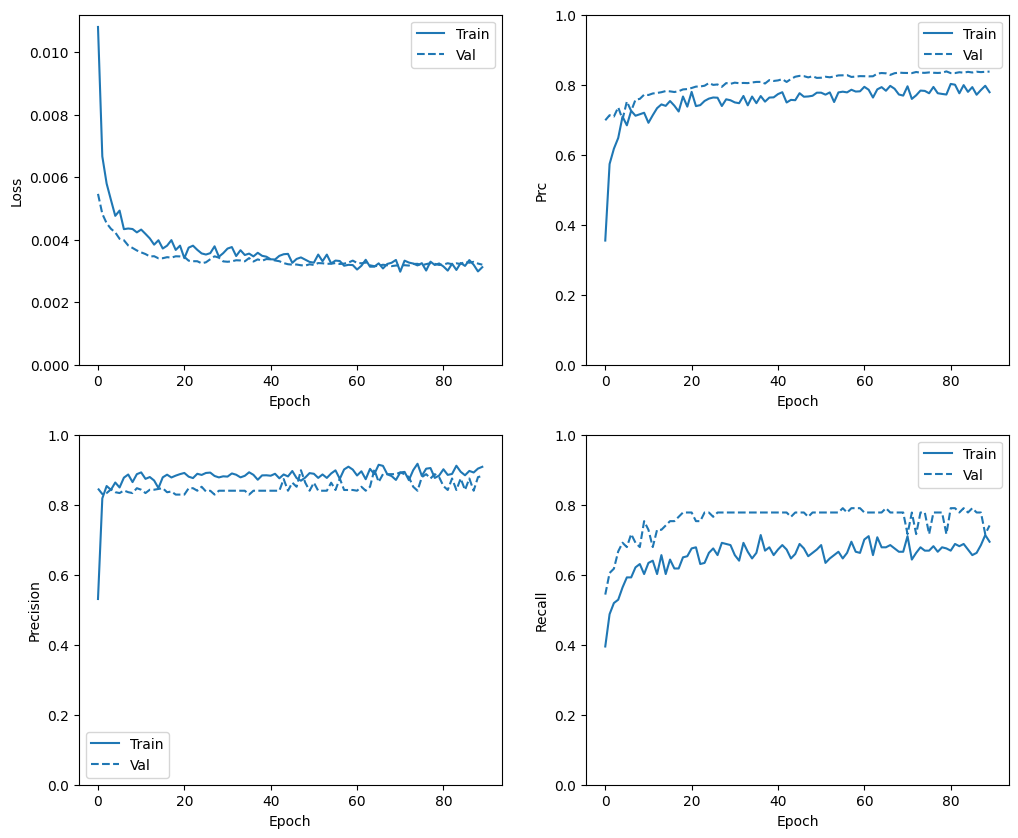

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.0034967793617397547
tp :  72.0
fp :  8.0
tn :  56857.0
fn :  25.0
accuracy :  0.9994206428527832
precision :  0.8999999761581421
recall :  0.7422680258750916
auc :  0.927476704120636
prc :  0.7999517917633057

Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  72
Total Fraudulent Transactions:  97


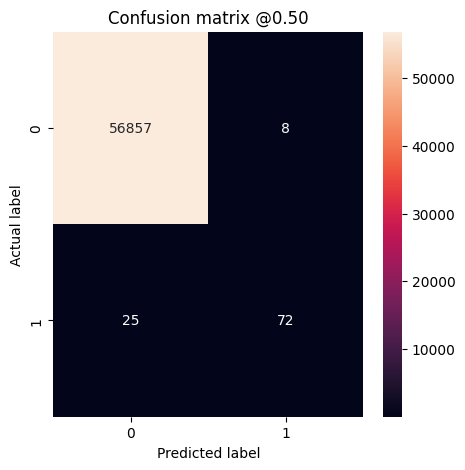

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

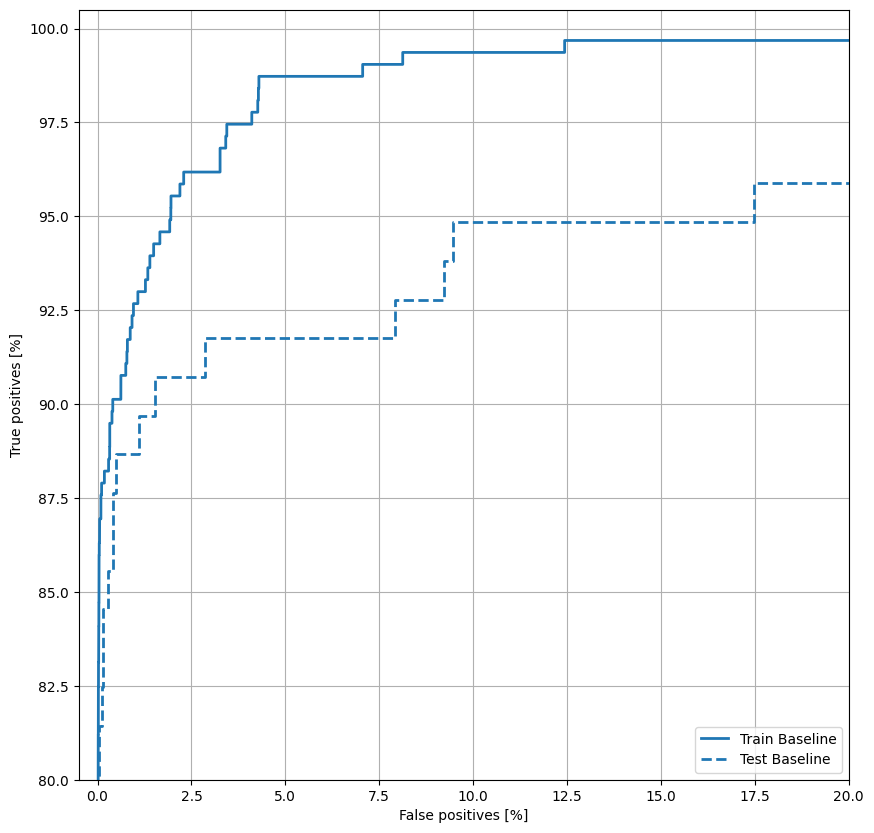

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

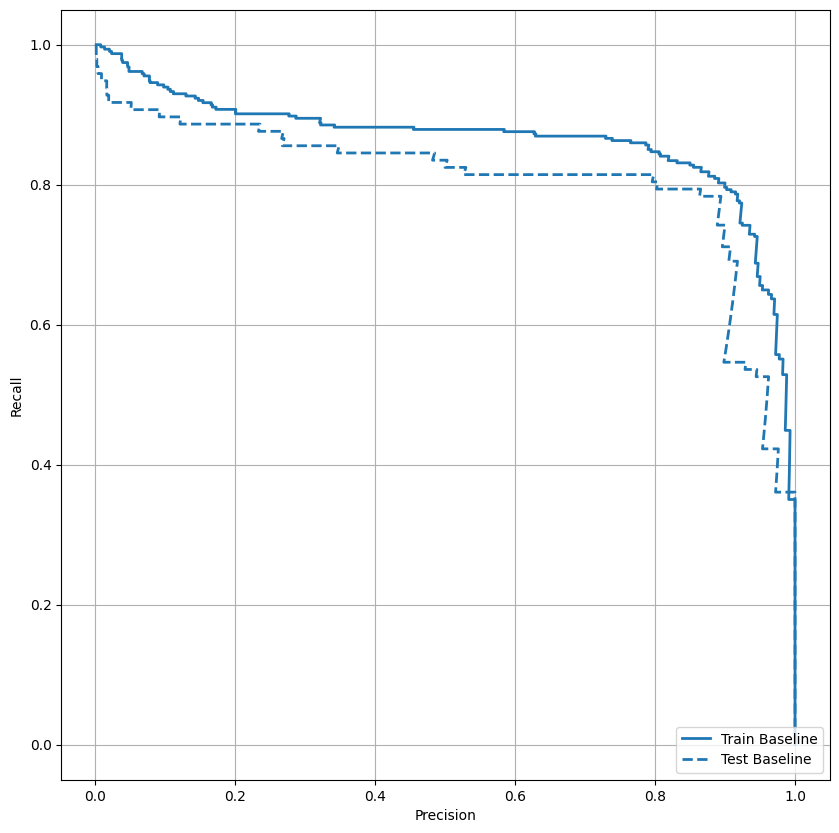

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 2s 11ms/step - loss: 1.1025 - tp: 210.0000 - fp: 588.0000 - tn: 238239.0000 - fn: 201.0000 - accuracy: 0.9967 - precision: 0.2632 - recall: 0.5109 - auc: 0.8965 - prc: 0.3408 - val_loss: 0.0114 - val_tp: 56.0000 - val_fp: 41.0000 - val_tn: 45447.0000 - val_fn: 25.0000 - val_accuracy: 0.9986 - val_precision: 0.5773 - val_recall: 0.6914 - val_auc: 0.9455 - val_prc: 0.6191
Epoch 2/100
90/90 [==============================] - 1s 6ms/step - loss: 0.5621 - tp: 223.0000 - fp: 1125.0000 - tn: 180837.0000 - fn: 91.0000 - accuracy: 0.9933 - precision: 0.1654 - recall: 0.7102 - auc: 0.9329 - prc: 0.4102 - val_loss: 0.0168 - val_tp: 67.0000 - val_fp: 81.0000 - val_tn: 45407.0000 - val_fn: 14.0000 - val_accuracy: 0.9979 - val_precision: 0.4527 - val_recall: 0.8272 - val_auc: 0.9617 - val_prc: 0.6582
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.4982 - tp: 229.0000 - fp: 1838.0000 - tn: 180124.0000 - fn: 85.0000 - accu

### Check training history

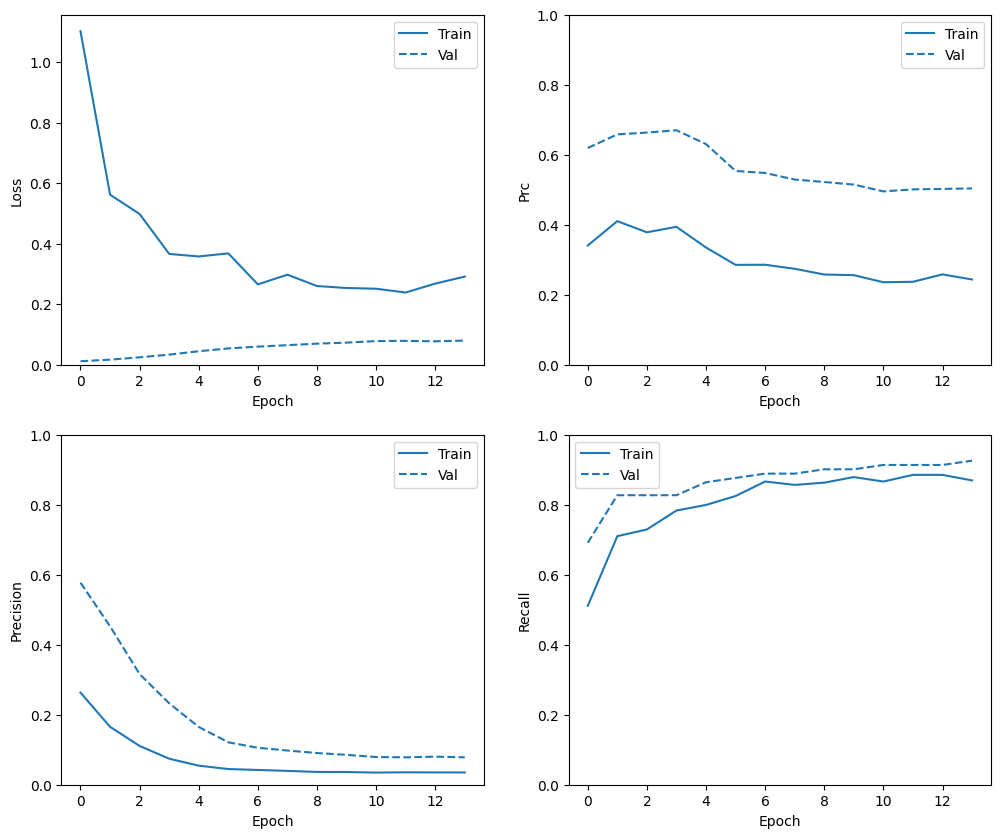

In [36]:
plot_metrics(weighted_history)

### Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss :  0.03274456411600113
tp :  81.0
fp :  252.0
tn :  56613.0
fn :  16.0
accuracy :  0.9952951073646545
precision :  0.2432432472705841
recall :  0.8350515365600586
auc :  0.9679247140884399
prc :  0.6531848311424255

Legitimate Transactions Detected (True Negatives):  56613
Legitimate Transactions Incorrectly Detected (False Positives):  252
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  97


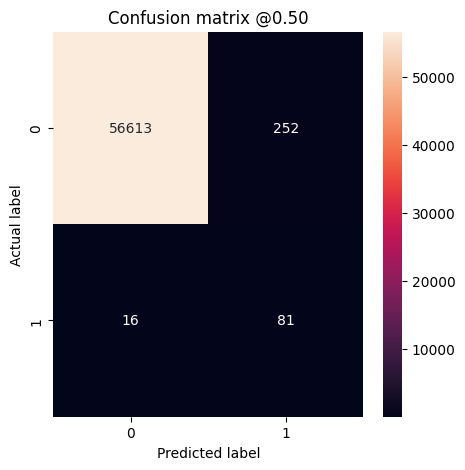

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

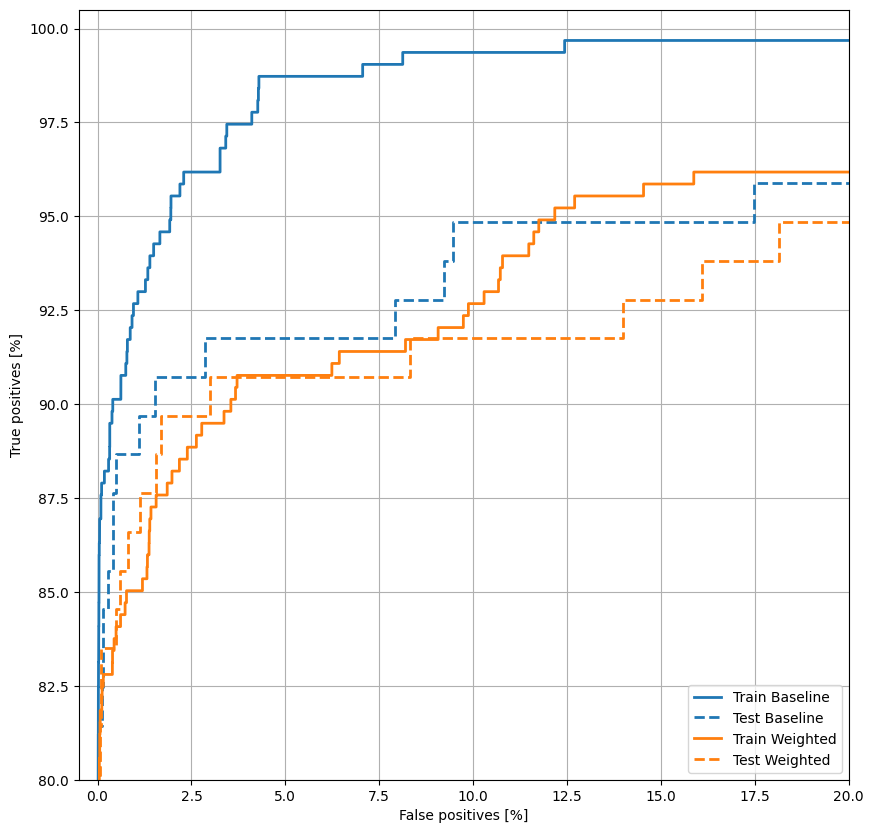

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

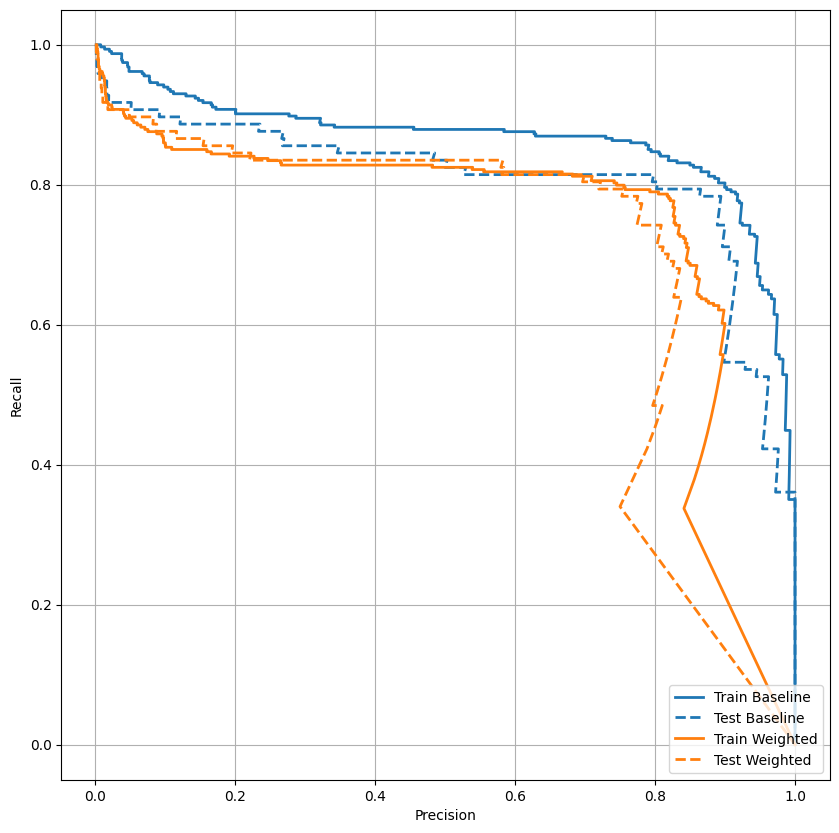

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181962, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363924, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.45352952  0.79696871 -0.66601721  1.19337228 -0.53348935 -0.59578957
 -2.0979605   0.8951992  -1.03275912 -3.61762633  2.51868193 -2.2973935
  0.56276617 -5.         -2.0200714  -2.99465523 -5.         -1.470018
  0.49047894  0.01528834  0.71729537  0.3147249  -1.19057248 -0.11189896
  0.41024869 -0.93852853  0.85165508  0.58924332 -0.06818104]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50927734375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 9s 26ms/step - loss: 0.3300 - tp: 261082.0000 - fp: 67295.0000 - tn: 274419.0000 - fn: 23510.0000 - accuracy: 0.8550 - precision: 0.7951 - recall: 0.9174 - auc: 0.9558 - prc: 0.9586 - val_loss: 0.1785 - val_tp: 75.0000 - val_fp: 1195.0000 - val_tn: 44293.0000 - val_fn: 6.0000 - val_accuracy: 0.9736 - val_precision: 0.0591 - val_recall: 0.9259 - val_auc: 0.9764 - val_prc: 0.7125
Epoch 2/100
278/278 [==============================] - 6s 23ms/step - loss: 0.1676 - tp: 264165.0000 - fp: 16889.0000 - tn: 267825.0000 - fn: 20465.0000 - accuracy: 0.9344 - precision: 0.9399 - recall: 0.9281 - auc: 0.9838 - prc: 0.9859 - val_loss: 0.0980 - val_tp: 75.0000 - val_fp: 974.0000 - val_tn: 44514.0000 - val_fn: 6.0000 - val_accuracy: 0.9785 - val_precision: 0.0715 - val_recall: 0.9259 - val_auc: 0.9755 - val_prc: 0.7231
Epoch 3/100
278/278 [==============================] - 6s 23ms/step - loss: 0.1284 - tp: 268163.0000 - fp: 12440.0000 - tn: 27129

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

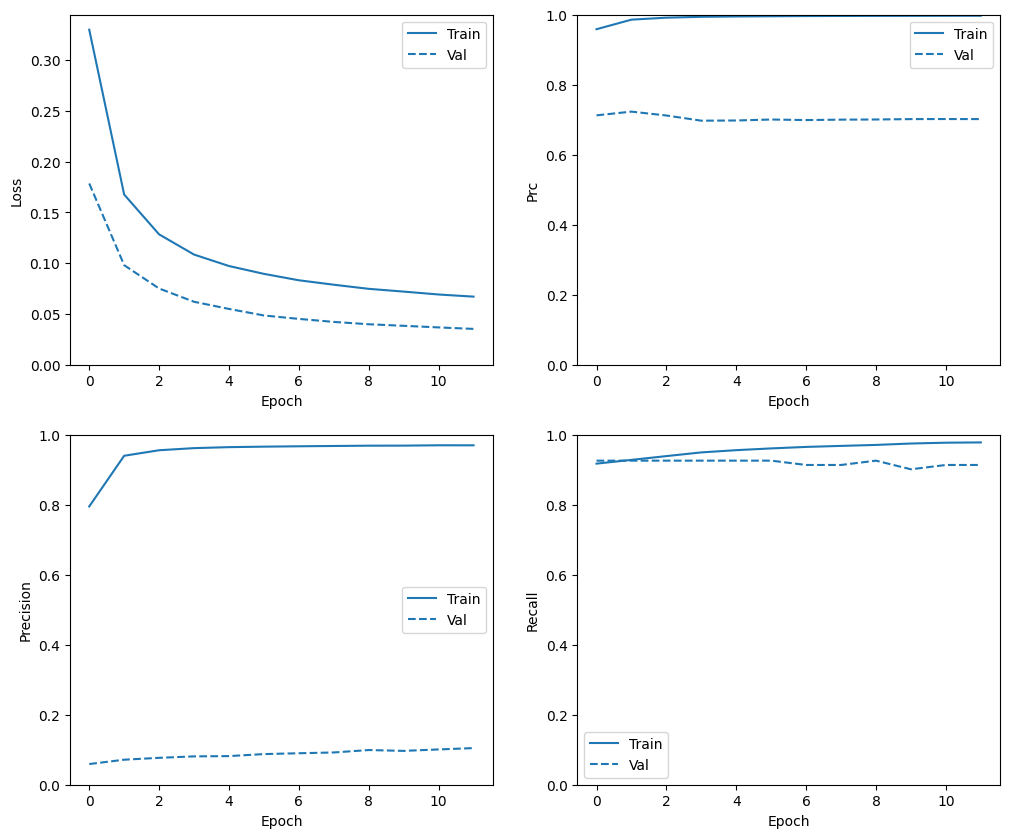

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 3s 51ms/step - loss: 0.6201 - tp: 18361.0000 - fp: 12180.0000 - tn: 53666.0000 - fn: 2322.0000 - accuracy: 0.8324 - precision: 0.6012 - recall: 0.8877 - auc: 0.9476 - prc: 0.8715 - val_loss: 0.8273 - val_tp: 78.0000 - val_fp: 24283.0000 - val_tn: 21205.0000 - val_fn: 3.0000 - val_accuracy: 0.4670 - val_precision: 0.0032 - val_recall: 0.9630 - val_auc: 0.9378 - val_prc: 0.4261
Epoch 2/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.5165 - tp: 18820.0000 - fp: 10072.0000 - tn: 10384.0000 - fn: 1684.0000 - accuracy: 0.7130 - precision: 0.6514 - recall: 0.9179 - auc: 0.8998 - prc: 0.9236 - val_loss: 0.6968 - val_tp: 76.0000 - val_fp: 18526.0000 - val_tn: 26962.0000 - val_fn: 5.0000 - val_accuracy: 0.5933 - val_precision: 0.0041 - val_recall: 0.9383 - val_auc: 0.9461 - val_prc: 0.5271
Epoch 3/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.4434 - tp: 19145.0000 - fp: 8327.0000 - tn: 11911.0000 - 

### Re-check training history

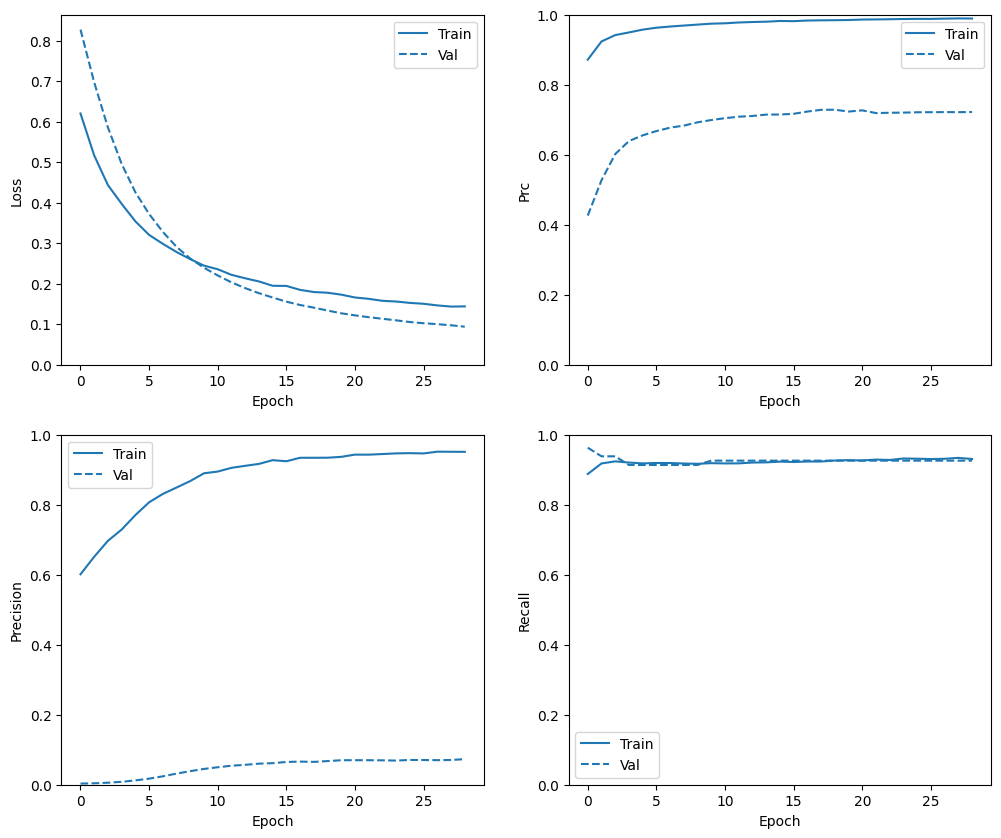

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


loss :  0.13431145250797272
tp :  87.0
fp :  1381.0
tn :  55484.0
fn :  10.0
accuracy :  0.9755802154541016
precision :  0.05926430597901344
recall :  0.8969072103500366
auc :  0.9665377140045166
prc :  0.7062013745307922

Legitimate Transactions Detected (True Negatives):  55484
Legitimate Transactions Incorrectly Detected (False Positives):  1381
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  97


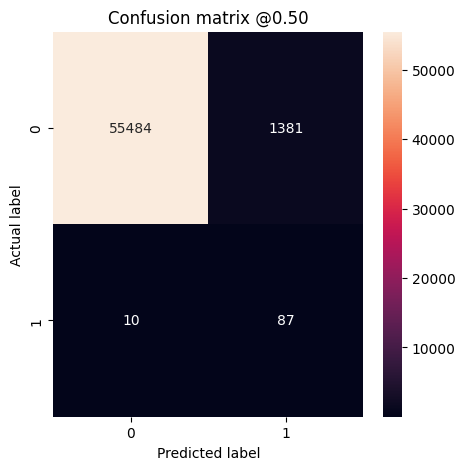

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

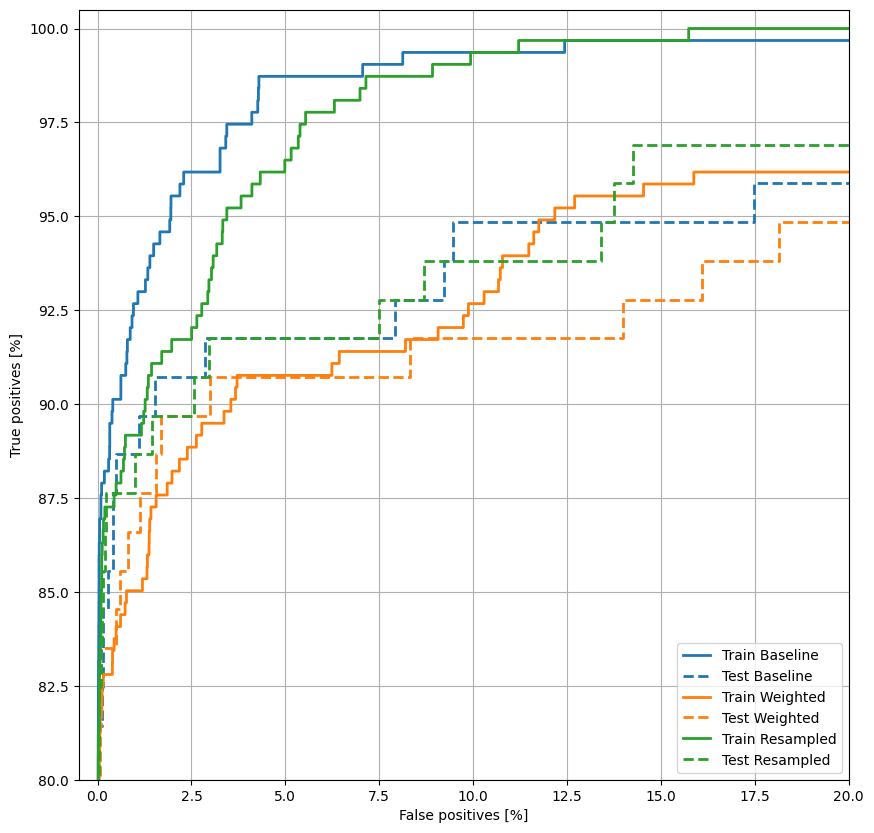

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


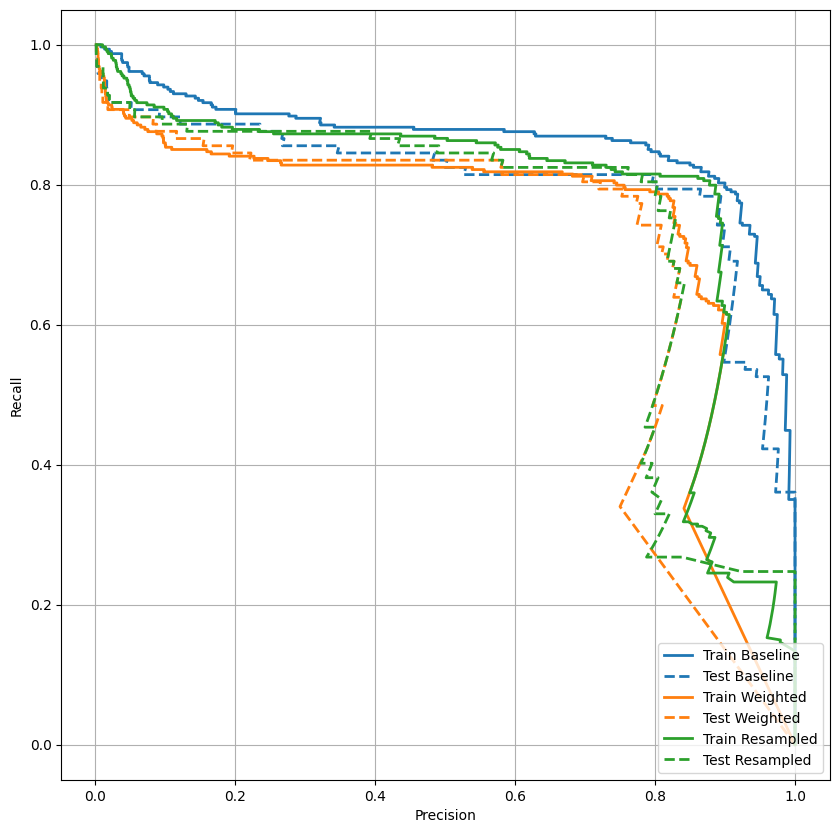

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.